In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import TransformerModel
from aco import ACO
from utils import gen_instance, reformat, load_val_dataset

torch.manual_seed(1234)

lr = 1e-3
EPS = 1e-10
ALPHA = 0.05
T=5
device = 'cuda:0'

In [2]:
def train_instance(model, optimizer, price, weight, n_ants):
    '''One instance a time by default
    '''
    model.train()
    src = reformat(price, weight)
    phe_vec, heu_vec = model(src)
    phe_vec, heu_vec = phe_vec.squeeze() + EPS, heu_vec.squeeze() + EPS
    
    aco = ACO(
        price=price,
        weight=weight,
        n_ants=n_ants,
        pheromone=phe_vec,
        heuristic=heu_vec,
        device=device
        )
    
    objs, log_probs_list = aco.sample()
    objs = torch.tensor(objs, device=device)
    baseline = objs.mean()
    reinforce_loss = 0
    for ant in range(n_ants):
        obj = objs[ant]
        log_probs = torch.stack(log_probs_list[ant])
        ant_loss = (baseline - obj) * log_probs.sum() 
        reinforce_loss += ant_loss
    reinforce_loss /= aco.n_ants
    entropy_loss = ALPHA * (-torch.sum(Categorical(phe_vec).entropy()) / len(phe_vec))
    loss = reinforce_loss + entropy_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def infer_instance(model, price, weight, n_ants):
    model.eval()
    src = reformat(price, weight)
    phe_vec, heu_vec = model(src)
    phe_vec, heu_vec = phe_vec.squeeze() + EPS, heu_vec.squeeze() + EPS
    aco = ACO(
        price=price,
        weight=weight,
        n_ants=n_ants,
        pheromone=phe_vec,
        heuristic=heu_vec,
        device=device
        )
    objs, log_probs = aco.sample()
    best_aco_obj, best_aco_sol = aco.run(n_iterations=T)
    objs = torch.tensor(objs, device=device)
    baseline = objs.mean()
    best_sample_obj = objs.max()
    return baseline.item(), best_sample_obj.item(), best_aco_obj.item()

In [3]:
def train_epoch(problem_size,
                n_ants, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        price, weight = gen_instance(problem_size, device=device)
        train_instance(net, optimizer, price, weight, n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    for price, weight in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, price, weight, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(problem_size, n_ants, steps_per_epoch, epochs):
    net = TransformerModel().to(device)
    print('total params:', sum(p.numel() for p in net.parameters())) 
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(problem_size, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(problem_size, n_ants, epoch, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/mkp/mkp{problem_size}.pt')

Train heuristic and pheromone generator for MKP20 (M=2): 

total training duration: 104.95733833312988
epoch -1: (4.640935755968094, 5.967397944927216, 6.379103214740753)
epoch 0: (5.081070739030838, 6.2396564030647275, 6.598877139091492)
epoch 1: (5.9726052308082584, 6.60797060251236, 6.703753366470337)
epoch 2: (6.31526603937149, 6.6488270092010495, 6.6913122773170475)
epoch 3: (6.466304247379303, 6.682572093009949, 6.700856564044952)
epoch 4: (6.506756575107574, 6.664723961353302, 6.685235033035278)


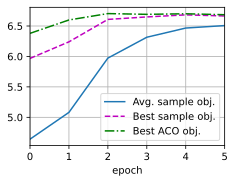

In [117]:
n_node, n_ants = 20, 20
steps_per_epoch = 32
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

total training duration: 3127.497300386429
epoch -1: (21.45418472290039, 25.01381845474243, 26.976240730285646)
epoch 0: (24.211184406280516, 27.72407646179199, 29.640957832336426)
epoch 1: (28.16140785217285, 30.867480087280274, 32.229101943969724)
epoch 2: (29.534600067138673, 31.33220672607422, 32.36164264678955)
epoch 3: (29.87339038848877, 31.334858322143553, 32.47978267669678)
epoch 4: (30.400793647766115, 31.824100494384766, 32.36800270080566)


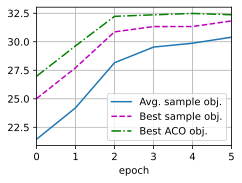

In [5]:
n_node, n_ants = 100, 50
steps_per_epoch = 32
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)